✅ Loaded meta: (1570, 3), groups=6


Augmenting v8 → v9:   0%|                                                                                                             | 0/1570 [00:00<?, ?it/s]/tmp/ipykernel_169150/832352349.py:45: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(20, 80), p=0.5),
/tmp/ipykernel_169150/832352349.py:48: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=30, quality_upper=90, p=0.5),
/data/ephemeral/home/py310/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_169150/832352349.py:50: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
/tmp/ipykernel_169150/832352349.py:36: UserWarning: Argument(s) 'value' are not valid for transf


✅ Augmentation complete!
📁 Saved to: ../../data/meta_stage0_9_train_v9.csv
📊 Total images: 14130 (≈ 1570 × 9)


/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


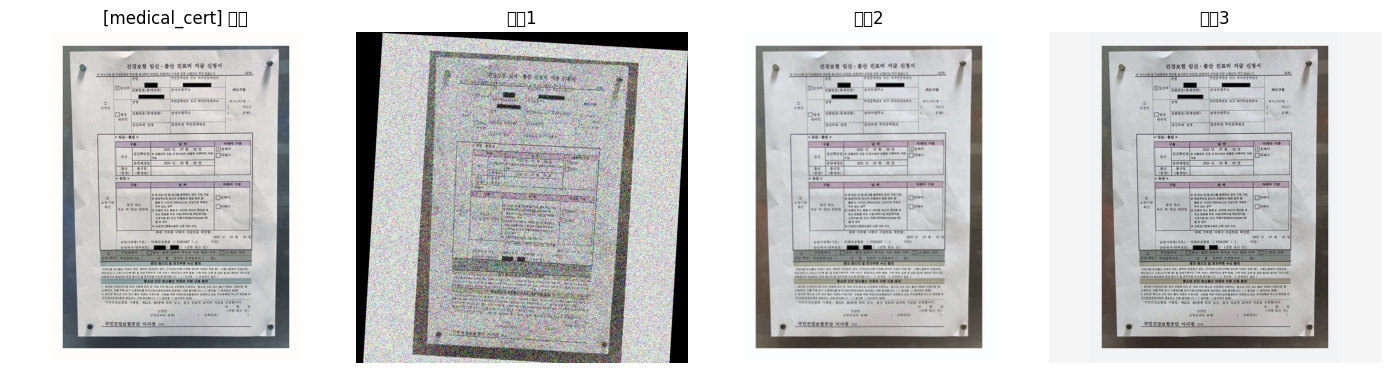

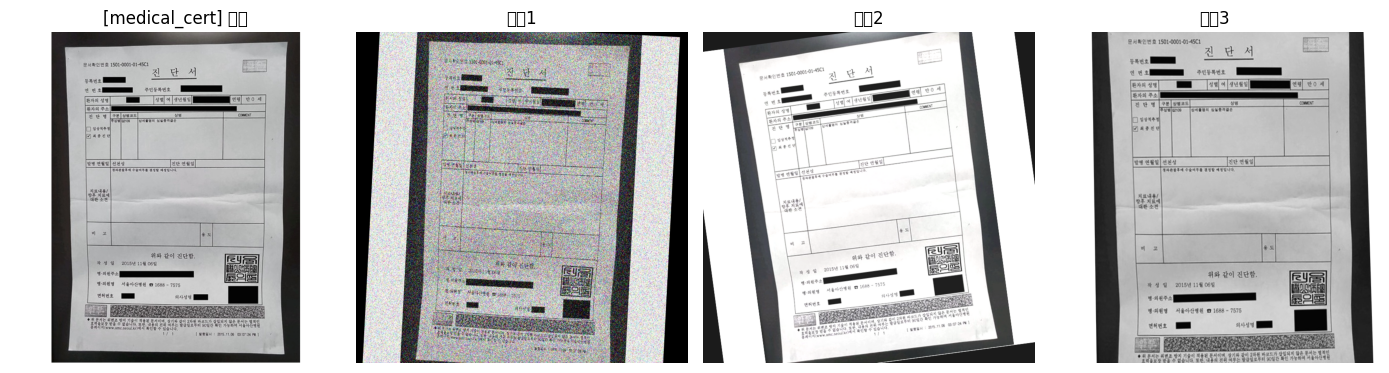

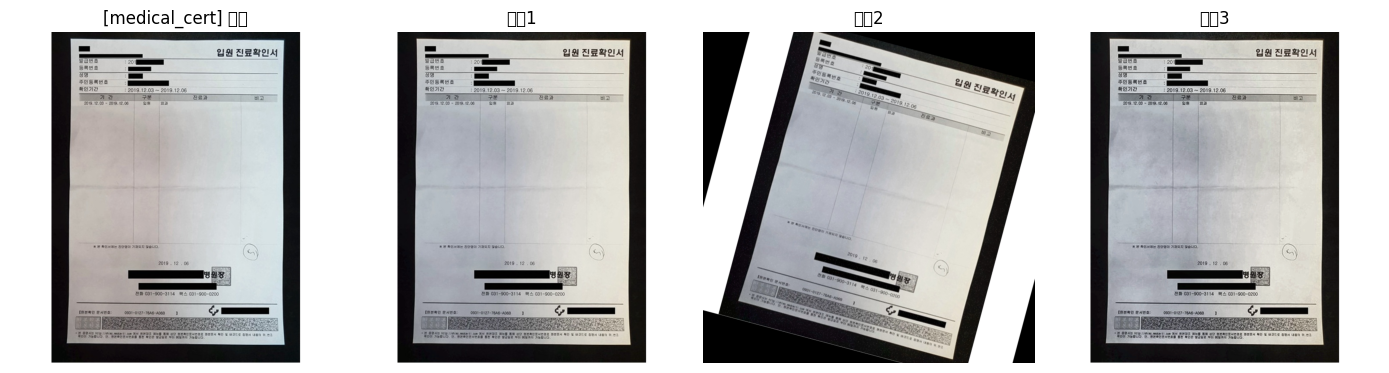

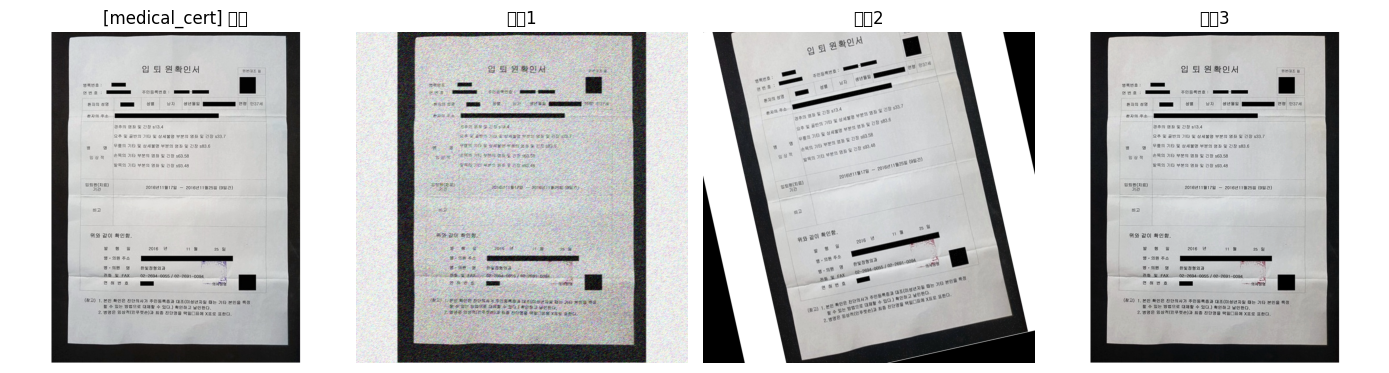

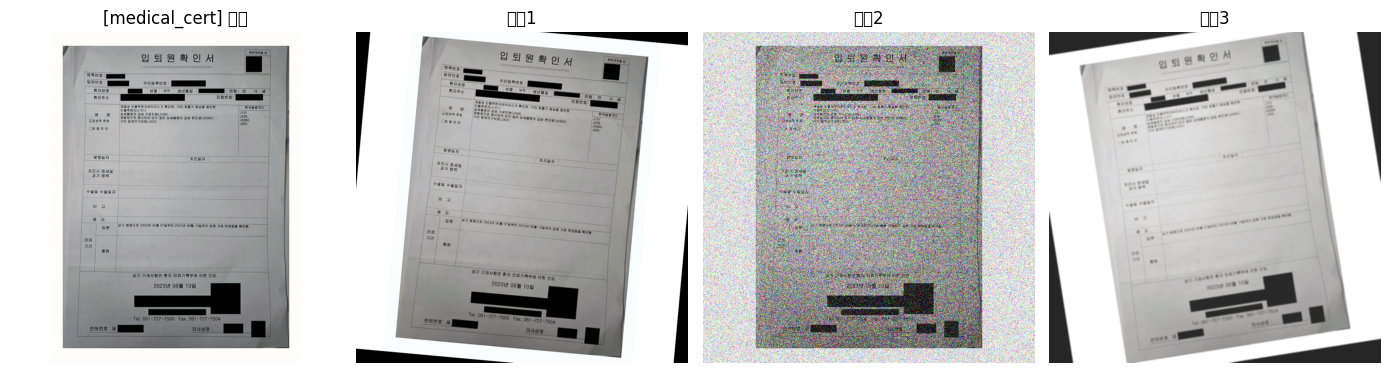

In [1]:
# ============================================================
# stage0_9_offline_augmentation_v8base_visual.py
# ------------------------------------------------------------
# - 입력 : ../../data/meta_stage0_8_train_v8.csv
# - 출력 : ../../data/meta_stage0_9_train_v9.csv
# - 폴더 : ../../data/processed/stage0_8_train_v8 → stage0_9_train_v9
# - 증강 : 원본 1 + 증강 8배 (총 9배)
# - 목적 : test domain 실사 환경 대응 (노이즈/조명/각도/압축 강화)
# - 추가 : 증강 샘플 5개 시각화 (원본 + 3개 증강)
# ============================================================

import os
import cv2
import random
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------------------------------------
# 1️⃣ 경로 설정
# ------------------------------------------------------------
BASE = "../../data"
SRC_META = f"{BASE}/meta_stage0_8_train_v8.csv"
SRC_DIR  = f"{BASE}/processed/stage0_8_train_v8"
DST_DIR  = f"{BASE}/processed/stage0_9_train_v9"
DST_META = f"{BASE}/meta_stage0_9_train_v9.csv"

os.makedirs(DST_DIR, exist_ok=True)

# ------------------------------------------------------------
# 2️⃣ 증강 Preset 정의 (3가지 조합)
# ------------------------------------------------------------
def preset_light():
    return A.Compose([
        A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, value=(255,255,255), p=0.6),
        A.RandomBrightnessContrast(0.25, 0.25, p=0.6),
        A.RandomGamma(gamma_limit=(80, 130), p=0.5),
        A.GaussianBlur(blur_limit=(3,5), p=0.3),
    ])

def preset_heavy():
    return A.Compose([
        A.OneOf([
            A.GaussNoise(var_limit=(20, 80), p=0.5),
            A.ISONoise(color_shift=(0.01, 0.06), intensity=(0.1, 0.4), p=0.5),
        ], p=0.9),
        A.ImageCompression(quality_lower=30, quality_upper=90, p=0.5),
        A.MotionBlur(blur_limit=(3, 7), p=0.3),
        A.ShiftScaleRotate(
            shift_limit=0.05, scale_limit=0.1, rotate_limit=15,
            border_mode=cv2.BORDER_CONSTANT, value=(255,255,255), p=0.7
        ),
    ])

def preset_color():
    return A.Compose([
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20, val_shift_limit=15, p=0.6),
        A.OneOf([
            A.CLAHE(clip_limit=(1, 2), tile_grid_size=(8,8), p=0.3),
            A.ToGray(p=0.3),
        ], p=0.6),
        A.Perspective(scale=(0.03, 0.08), keep_size=True, p=0.4),
    ])

PRESETS = [preset_light, preset_heavy, preset_color]

# ------------------------------------------------------------
# 3️⃣ 메타데이터 로드
# ------------------------------------------------------------
df = pd.read_csv(SRC_META)
print(f"✅ Loaded meta: {df.shape}, groups={df['group'].nunique()}")

# ------------------------------------------------------------
# 4️⃣ 증강 수행
# ------------------------------------------------------------
records = []
AUG_PER_IMAGE = 8  # 원본당 8개 생성 (총 9배)

for _, row in tqdm(df.iterrows(), total=len(df), desc="Augmenting v8 → v9"):
    src_path = row["filepath"]
    group = row["group"]
    base = row["basename"]

    src_full = os.path.join(SRC_DIR, group, base)
    dst_group_dir = os.path.join(DST_DIR, group)
    os.makedirs(dst_group_dir, exist_ok=True)

    img = cv2.imread(src_full)
    if img is None:
        print(f"⚠️ Cannot read: {src_full}")
        continue

    # (1) 원본 복사
    dst_path = os.path.join(dst_group_dir, base)
    if not os.path.exists(dst_path):
        cv2.imwrite(dst_path, img, [cv2.IMWRITE_JPEG_QUALITY, 95])
    records.append({"filepath": dst_path, "group": group, "basename": base})

    # (2) 증강 생성
    for i in range(AUG_PER_IMAGE):
        preset_fn = random.choice(PRESETS)
        aug = preset_fn()
        aug_img = aug(image=img)["image"]
        new_name = f"{os.path.splitext(base)[0]}_aug{i+1}.jpg"
        dst_aug_path = os.path.join(dst_group_dir, new_name)
        cv2.imwrite(dst_aug_path, aug_img, [cv2.IMWRITE_JPEG_QUALITY, 95])
        records.append({"filepath": dst_aug_path, "group": group, "basename": new_name})

# ------------------------------------------------------------
# 5️⃣ 결과 CSV 저장
# ------------------------------------------------------------
out_df = pd.DataFrame(records)
out_df.to_csv(DST_META, index=False)
print(f"\n✅ Augmentation complete!")
print(f"📁 Saved to: {DST_META}")
print(f"📊 Total images: {len(out_df)} (≈ {len(df)} × 9)")

# ------------------------------------------------------------
# 6️⃣ 시각화: 원본 + 증강 3개 비교
# ------------------------------------------------------------
sample_df = df.sample(5, random_state=42)

for _, row in sample_df.iterrows():
    src_full = os.path.join(SRC_DIR, row["group"], row["basename"])
    img = cv2.cvtColor(cv2.imread(src_full), cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 4, figsize=(14, 4))
    axes[0].imshow(img)
    axes[0].set_title(f"[{row['group']}] 원본")
    axes[0].axis("off")

    # 증강 3종 생성 및 표시
    for i in range(3):
        preset_fn = random.choice(PRESETS)
        aug = preset_fn()
        aug_img = aug(image=img)["image"]
        axes[i+1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axes[i+1].set_title(f"증강{i+1}")
        axes[i+1].axis("off")

    plt.tight_layout()
    plt.show()


In [3]:
# ------------------------------------------------------------
# 7️⃣ 전후 통계 비교 (밝기/대비/노이즈)
# ------------------------------------------------------------
import numpy as np
def compute_stats(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness = gray.mean()
    contrast = gray.std()
    noise = cv2.Laplacian(gray, cv2.CV_64F).var()
    return brightness, contrast, noise

orig_stats, aug_stats = [], []

sample_df2 = df.sample(100, random_state=123)

for _, row in tqdm(sample_df2.iterrows(), total=len(sample_df2), desc="Computing stats"):
    src_full = os.path.join(SRC_DIR, row["group"], row["basename"])
    img = cv2.imread(src_full)
    if img is None:
        continue
    b, c, n = compute_stats(img)
    orig_stats.append((b, c, n))

    # 임의의 증강 이미지 1개
    preset_fn = random.choice(PRESETS)
    aug = preset_fn()
    aug_img = aug(image=img)["image"]
    b2, c2, n2 = compute_stats(aug_img)
    aug_stats.append((b2, c2, n2))

orig_stats, aug_stats = np.array(orig_stats), np.array(aug_stats)

summary = pd.DataFrame({
    "Metric": ["Brightness", "Contrast", "NoiseVar"],
    "Original_Mean": orig_stats.mean(axis=0),
    "Augmented_Mean": aug_stats.mean(axis=0),
    "Δ Change (%)": 100 * (aug_stats.mean(axis=0) - orig_stats.mean(axis=0)) / (orig_stats.mean(axis=0) + 1e-6)
})

print("\n📊 전처리 전후 이미지 통계 비교")
print(summary.round(2))

Computing stats:   0%|                                                                                                                 | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_169150/832352349.py:36: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, value=(255,255,255), p=0.6),
/tmp/ipykernel_169150/832352349.py:45: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(20, 80), p=0.5),
/tmp/ipykernel_169150/832352349.py:48: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=30, quality_upper=90, p=0.5),
/tmp/ipykernel_169150/832352349.py:50: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(
Computing stats: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 


📊 전처리 전후 이미지 통계 비교
       Metric  Original_Mean  Augmented_Mean  Δ Change (%)
0  Brightness         187.24          175.24         -6.41
1    Contrast          66.52           69.05          3.80
2    NoiseVar         894.75         2136.53        138.79
